# Bifurcation Existence Verification for Box Beam Reinforced with Ribs

## Problem definition <a name="problem"></a>

***

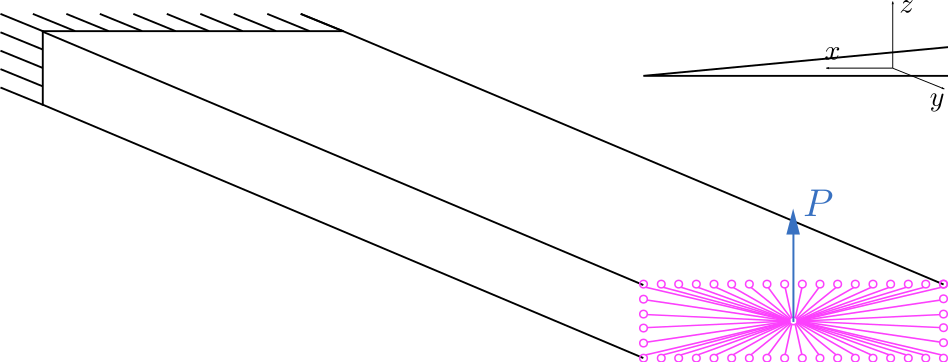

In [74]:
from IPython.display import SVG  # class to embed an SVG into the display
import os  # module with miscellaneous operating system interfaces

SVG(filename=os.path.join('resources', '08_ReinforcedBoxBeamConcentratedLoad.svg'))

In [75]:
AR = 9.   # aspect ratio - 2*b/w (the span of the box beam corresponds to half the span of the CRM wing)
w = 1e3   # width [mm]
b = AR*w/2  # span [mm]
non_dimensional_height = 0.2  # h/w
h = w*non_dimensional_height  # box height [mm]
non_dimensional_thickness = 1/50  # t/h
t = h*non_dimensional_thickness   # shell thickness [mm]
print(f'Box beam dimensions:\n- width: {w/1e3:.1f} m\n- span: {b/1e3:.1f} m\n- height: {h/1e3:.1f} m\n- wall thickness: {t:.1f} mm')

Box beam dimensions:
- width: 1.0 m
- span: 4.5 m
- height: 0.2 m
- wall thickness: 4.0 mm


In [76]:
import numpy as np

ribs_spacing = w/2
no_ribs = int(np.ceil(b/ribs_spacing)) + 1  # calculate number of ribs
ribs_y_locations = np.linspace(0, b, no_ribs)  # calculate y-coordinates of the ribs

# Print information to screen
np.set_printoptions(precision=1)
print(f'Number of ribs: {no_ribs:.0f}')
print(f'Ribs nondimensional spanwise location:')
print(ribs_y_locations/b)

Number of ribs: 10
Ribs nondimensional spanwise location:
[0.  0.1 0.2 0.3 0.4 0.6 0.7 0.8 0.9 1. ]


In [77]:
rho = 2780e-12 # density [ton/mm^3]
E = 73.1e3 # Young's modulus [MPa]
nu = 0.3 # Poisson's ratio

## Setup of the numerical model <a name="numerical-model"></a>

***

### Mesh and boundary conditions

In [78]:
from resources import box_beam_utils

shell_size = 49  # [mm]
box_beam_mesh = box_beam_utils.mesh_box_beam_with_pyvista(ribs_y_coordinates=ribs_y_locations, width=w, height=h, edge_length=shell_size)
nodes_xyz_array = box_beam_mesh.points
nodes_connectivity_matrix = box_beam_mesh.faces.reshape(-1, 5)[:, 1:]
box_beam_bdf_input = box_beam_utils.create_base_bdf_input(young_modulus=E, poisson_ratio=nu, density=rho, shell_thickness=t, nodes_xyz_array=nodes_xyz_array, nodes_connectivity_matrix=nodes_connectivity_matrix)
print(box_beam_bdf_input.get_bdf_stats())

---BDF Statistics---
SOL None

bdf.spcs[1]: 1
  SPC1:    1

bdf.params: 0
  PARAM    : 1

bdf.nodes: 0
  GRID     : 7154

bdf.elements: 0
  CQUAD4   : 7368

bdf.properties: 0
  PSHELL   : 1

bdf.materials: 0
  MAT1     : 1




subcase=0 already exists...skipping


### Load

In [79]:
# Add master node at the center of the tip section
master_node_id = np.size(nodes_xyz_array, 0) + 1
box_beam_bdf_input.add_grid(master_node_id, [w/2, b, 0.])

# Find id of the nodes on the edge of the tip rib
tolerance = shell_size/100  # we define a geometric tolerance to find the nodes on the edge of the tip rib equal to 1% of the shell size
tip_edge_nodes_ids = [nid for nid in box_beam_bdf_input.nodes if (np.abs(box_beam_bdf_input.nodes[nid].xyz[1] - b) < tolerance) & (np.abs((box_beam_bdf_input.nodes[nid].xyz[0]) < tolerance) | (np.abs(box_beam_bdf_input.nodes[nid].xyz[0] - w) < tolerance) | (np.abs(box_beam_bdf_input.nodes[nid].xyz[2] - h/2) < tolerance) | (np.abs(box_beam_bdf_input.nodes[nid].xyz[2] + h/2) < tolerance))]

# Add RBE3 to connect master node with edge nodes of tip rib
rbe3_eid = len(box_beam_bdf_input.elements) + 1
box_beam_bdf_input.add_rbe3(eid=rbe3_eid, refgrid=master_node_id, refc='123456', weights=[1.]*len(tip_edge_nodes_ids), comps=['123456']*len(tip_edge_nodes_ids), Gijs=tip_edge_nodes_ids)

# Add concentrated force
force_set_id = 11
force_magnitude = 1.
force_direction = [0., 0., 1.]
box_beam_bdf_input.add_force(sid=force_set_id, node=master_node_id, mag=force_magnitude, xyz=force_direction)

FORCE         11    7155              1.      0.      0.      1.

## Bifurcation existence verification

***

1. Concentrated tip load, $EPSP=10^{-1}, EPSW=10^{-1}, \Delta\mu^1=0.1, DESITER=12, MAXALR=4$
2. No load, $EPSP=10^{-1}, EPSW=10^{-1}, \Delta\mu^1=0.01, DESITER=5, MAXALR=1.01$

In [80]:
from resources import pynastran_utils  # module with useful functions to work with pyNastran objects

# Create subcase where we apply the buckling load predicted by SOL 105
sol_105_buckling_load = 3094.  # [N]
load_set_id = force_set_id + 1  # define id of load set
loading_subcase_id = 1
box_beam_bdf_input.add_load(sid=load_set_id, scale=1., scale_factors=[sol_105_buckling_load*2], load_ids=[force_set_id])  # add LOAD card to define load set
pynastran_utils.create_static_load_subcase(bdf_object=box_beam_bdf_input, subcase_id=loading_subcase_id, load_set_id=load_set_id)  # create subcase with defined load set
pynastran_utils.set_up_arc_length_method(box_beam_bdf_input, subcase_id=loading_subcase_id, eps_p=1e-1, eps_w=1e-1)  # set up SOL 106 with arc-length method using default parameters

# Define load set with no applied force
zero_load_set_id = load_set_id + 1
box_beam_bdf_input.add_load(zero_load_set_id, scale=1., scale_factors=[0.], load_ids=[force_set_id])

# Create second subcase
unloading_subcase_id = 2
pynastran_utils.create_static_load_subcase(bdf_object=box_beam_bdf_input, subcase_id=unloading_subcase_id, load_set_id=zero_load_set_id)
pynastran_utils.set_up_arc_length_method(bdf_object=box_beam_bdf_input, nlparm_id=unloading_subcase_id, eps_p=1e-1, eps_w=1e-1, ninc=100, desiter=5, minalr=1e-2, maxalr=1.01, maxinc=40, subcase_id=unloading_subcase_id)

Run analysis and calculate lowest eigenvalue of tangent stiffness matrix for each converged iteration.

In [81]:
analysis_directory_name = '15_Bifurcation_Existence_Verification_for_the_Box_Beam_Reinforced_with_Ribs'
analysis_directory_path = os.path.join(os.getcwd(), 'analyses', analysis_directory_name)
input_filename = 'bifurcation_verification_2Psol105_epsp1e-1'
no_eigenvalues = 6
op2_output_2Psol105_epsp1em1 = pynastran_utils.run_tangent_stiffness_matrix_eigenvalue_calculation(bdf_object=box_beam_bdf_input.__deepcopy__({}), method_set_id=zero_load_set_id+1, no_eigenvalues=no_eigenvalues, analysis_directory_path=analysis_directory_path, input_name=input_filename, run_flag=False)

Nastran job bifurcation_verification_2Psol105_epsp1e-1.bdf completed
Wall time: 163.0 s


Read load-displacement history from `OP2` object and plot load-displacement diagram for each subcase.

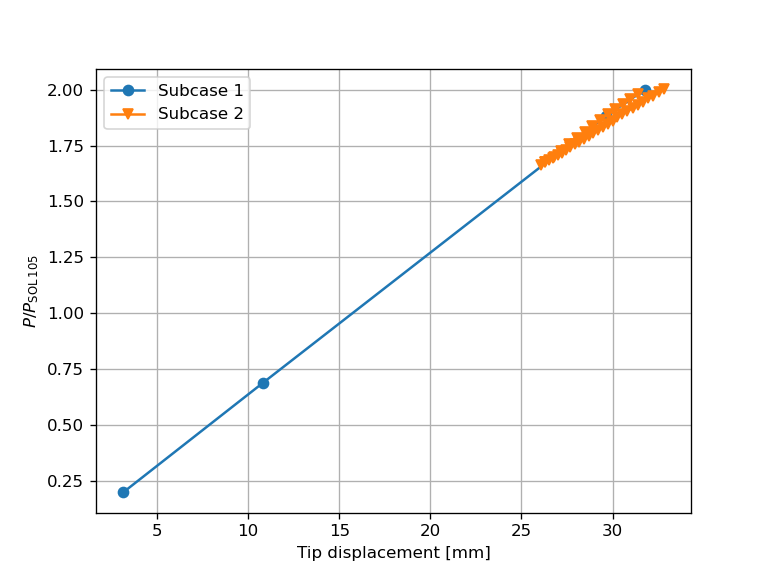

In [82]:
from matplotlib.lines import Line2D  # class defining the characters for the marker styles
import matplotlib.pyplot as plt  # plotting package

markers = list(Line2D.markers.keys())[2:]  # list of marker characters
plt.rcParams['figure.dpi'] = 120  # default dpi of figures
displacement_component_index = 2
load_component_index = 2

def plot_load_displacement_diagram(disp, loads):
    _, load_displacement_ax = plt.subplots()
    for subcase in loads:
        load_displacement_ax.plot(disp[subcase][:, displacement_component_index], loads[subcase][:, load_component_index]/sol_105_buckling_load, marker=markers[subcase - 1], label=f'Subcase {subcase:d}')
    load_displacement_ax.legend()
    plt.xlabel('Tip displacement [mm]')
    plt.ylabel('$P/P_\mathrm{SOL\/105}$')
    plt.grid()
    plt.show()

_, applied_loads_2Psol105_epsp1em1, tip_displacements_2Psol105_epsp1em1 = pynastran_utils.read_load_displacement_history_from_op2(op2_object=op2_output_2Psol105_epsp1em1, displacement_node_id=master_node_id)
plot_load_displacement_diagram(tip_displacements_2Psol105_epsp1em1, applied_loads_2Psol105_epsp1em1)

Read eigenvalues of tangent stiffness matrix from f06 file and plot them against the iteration number and the applied load.

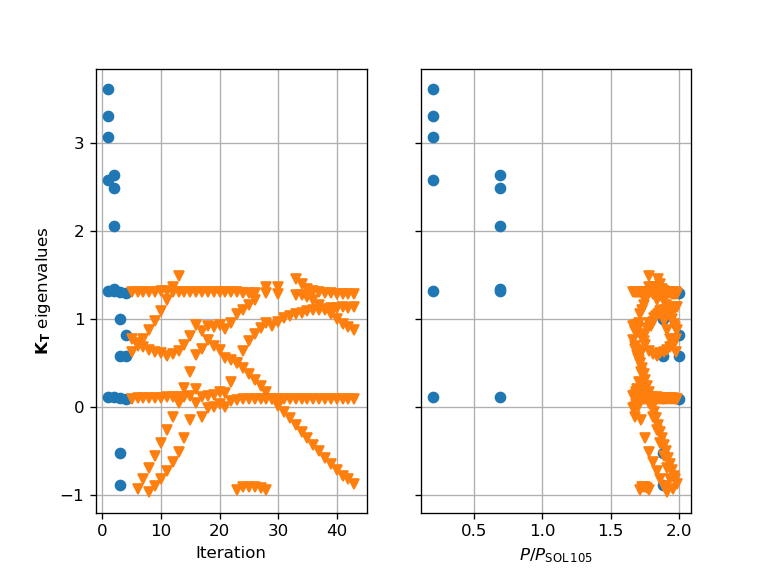

In [83]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_tangent_stiffness_matrix_eigenvalues(directory_path, input_name, loads):
    # Read eigenvalues
    f06_path = os.path.join(directory_path, input_name + '.f06')  # path to .f06 file
    eigvals = pynastran_utils.read_kllrh_lowest_eigenvalues_from_f06(f06_path)
    # Create figure with 2 subplots
    _, eigvals_axs = plt.subplots(nrows=1, ncols=2, sharey='all')
    iterations_count = 1
    # Divide lowest eigenvalues by subcase
    eigenvalues_count = 0
    eigenvalues_by_subcase = {}
    for subcase in loads:
        no_load_steps = len(loads[subcase])
        eigenvalues_by_subcase[subcase] = eigvals[:, eigenvalues_count:eigenvalues_count + no_load_steps]
        eigenvalues_count += no_load_steps
        # Plot eigenvalues vs iteration number
        eigvals_axs[0].plot(np.arange(iterations_count, eigenvalues_by_subcase[subcase].shape[1] + iterations_count), eigenvalues_by_subcase[subcase].T, markers[subcase - 1], color=colors[subcase - 1], label=f'Subcase {subcase:d}')
        iterations_count += eigenvalues_by_subcase[subcase].shape[1]
        # Plot eigenvalues vs applied load
        eigvals_axs[1].plot(loads[subcase][:eigenvalues_by_subcase[subcase].shape[1], displacement_component_index]/sol_105_buckling_load, eigenvalues_by_subcase[subcase].T, markers[subcase - 1], color=colors[subcase - 1])
    # Set plot appearance
    # axs[0].legend()
    eigvals_axs[0].set_xlabel('Iteration')
    eigvals_axs[0].set_ylabel('$\mathbf{K_T}$ eigenvalues')
    eigvals_axs[0].grid(visible=True)
    eigvals_axs[1].set_xlabel('$P/P_\mathrm{SOL\/105}$')
    eigvals_axs[1].grid(visible=True)
    plt.show()

plot_tangent_stiffness_matrix_eigenvalues(analysis_directory_path, input_filename, applied_loads_2Psol105_epsp1em1)

Try to unload structure with Newton method to verify whether the found path is separated from the natural one.

In [84]:
# Modify second subcase
# box_beam_bdf_input.nlparms[2].max_iter = 50
del box_beam_bdf_input.nlpcis[2]

In [85]:
input_filename = 'bifurcation_verification_2Psol105_epsp1e-1_newton'
op2_output = pynastran_utils.run_tangent_stiffness_matrix_eigenvalue_calculation(bdf_object=box_beam_bdf_input.__deepcopy__({}), method_set_id=zero_load_set_id+1, no_eigenvalues=no_eigenvalues, analysis_directory_path=analysis_directory_path, input_name=input_filename, run_flag=False)

Nastran job bifurcation_verification_2Psol105_epsp1e-1_newton.bdf completed
Wall time: 296.0 s


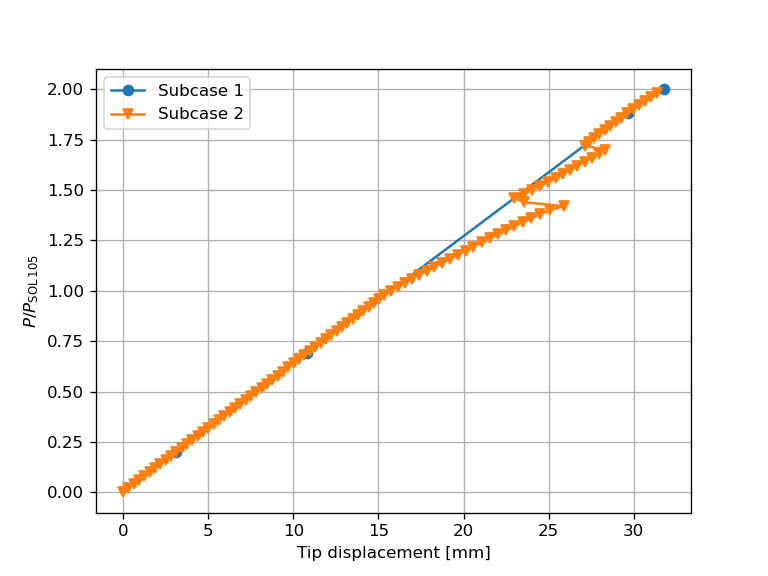

In [86]:
_, applied_loads, tip_displacements = pynastran_utils.read_load_displacement_history_from_op2(op2_object=op2_output, displacement_node_id=master_node_id)
plot_load_displacement_diagram(tip_displacements, applied_loads)

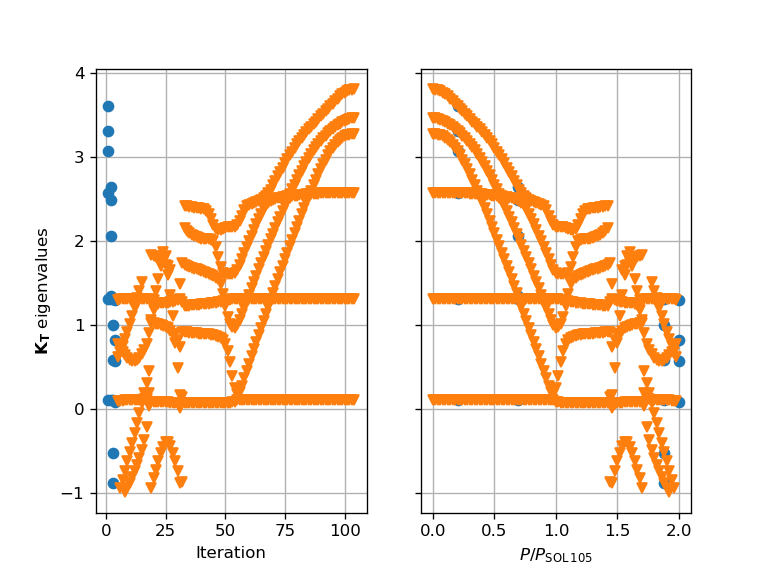

In [87]:
plot_tangent_stiffness_matrix_eigenvalues(analysis_directory_path, input_filename, applied_loads)

Rerun analysis for $EPSP=10^{-3}, EPSW=10^{-7}$.

In [88]:
# Modify convergence tolerance of subcases 1 and 2
for subcase_id in range(1, 3):
    box_beam_bdf_input.nlparms[subcase_id].eps_p = 1e-3
    box_beam_bdf_input.nlparms[subcase_id].eps_w = 1e-7

# Reinstate arc-length method for second subcase
box_beam_bdf_input.add_nlpci(nlpci_id=unloading_subcase_id, Type='CRIS', minalr=1e-2, maxalr=1.01, desiter=5, mxinc=60)

NLPCI          2    CRIS     .01    1.01      0.               5      60

In [89]:
input_filename = 'bifurcation_verification_2Psol105_epsp1e-3'
op2_output = pynastran_utils.run_tangent_stiffness_matrix_eigenvalue_calculation(bdf_object=box_beam_bdf_input.__deepcopy__({}), method_set_id=zero_load_set_id+1, no_eigenvalues=no_eigenvalues, analysis_directory_path=analysis_directory_path, input_name=input_filename, run_flag=False)

Nastran job bifurcation_verification_2Psol105_epsp1e-3.bdf completed
Wall time: 234.0 s


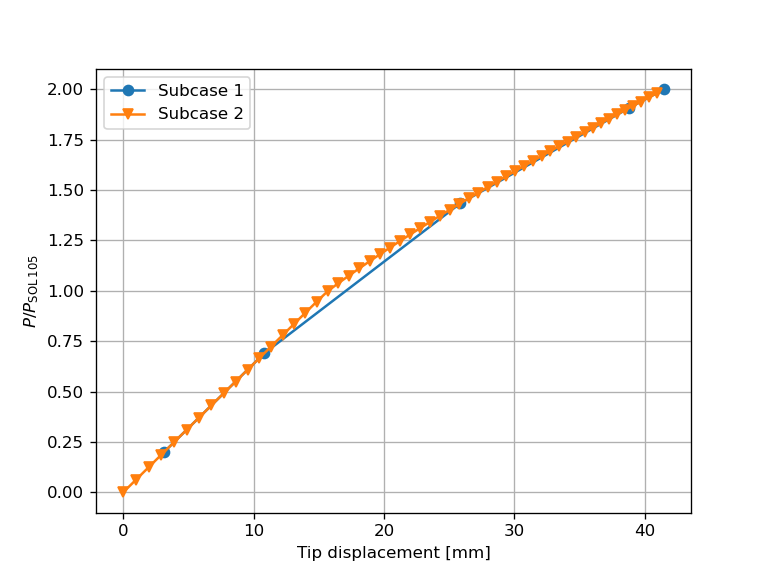

In [90]:
_, applied_loads, tip_displacements = pynastran_utils.read_load_displacement_history_from_op2(op2_object=op2_output, displacement_node_id=master_node_id)
plot_load_displacement_diagram(tip_displacements, applied_loads)

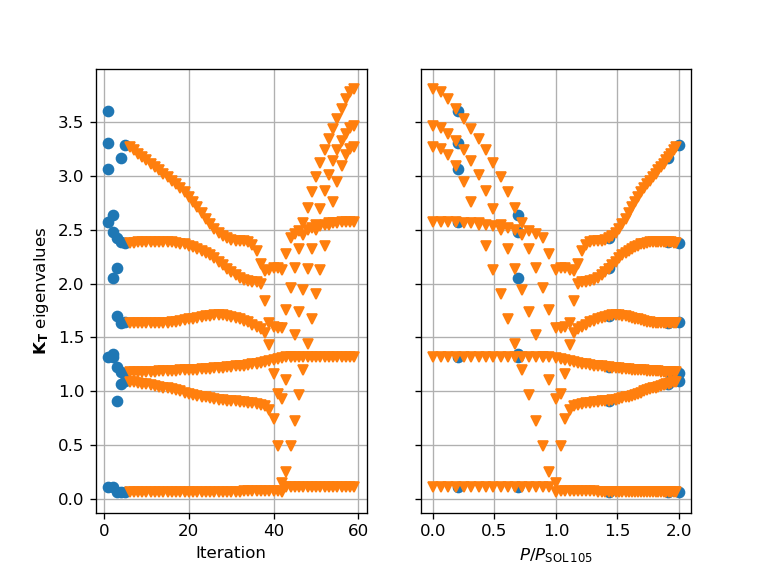

In [91]:
plot_tangent_stiffness_matrix_eigenvalues(analysis_directory_path, input_filename, applied_loads)

Let's investigate other possible bifurcation below $P/P_\text{SOL 105}=1.7$.

In [92]:
load_factor = 1.6
box_beam_bdf_input.load_combinations[load_set_id][0].scale_factors[0] = sol_105_buckling_load*load_factor  # modify applied load
box_beam_bdf_input.nlpcis[unloading_subcase_id].mxinc = 105

In [93]:
input_filename = f'bifurcation_verification_{load_factor:.1f}Psol105_epsp1e-3'.replace('.','_')
op2_output_1_6Psol105_epsp1em3 = pynastran_utils.run_tangent_stiffness_matrix_eigenvalue_calculation(bdf_object=box_beam_bdf_input.__deepcopy__({}), method_set_id=zero_load_set_id+1, no_eigenvalues=no_eigenvalues, analysis_directory_path=analysis_directory_path, input_name=input_filename, run_flag=False)

Nastran job bifurcation_verification_1_6Psol105_epsp1e-3.bdf completed
Wall time: 414.0 s


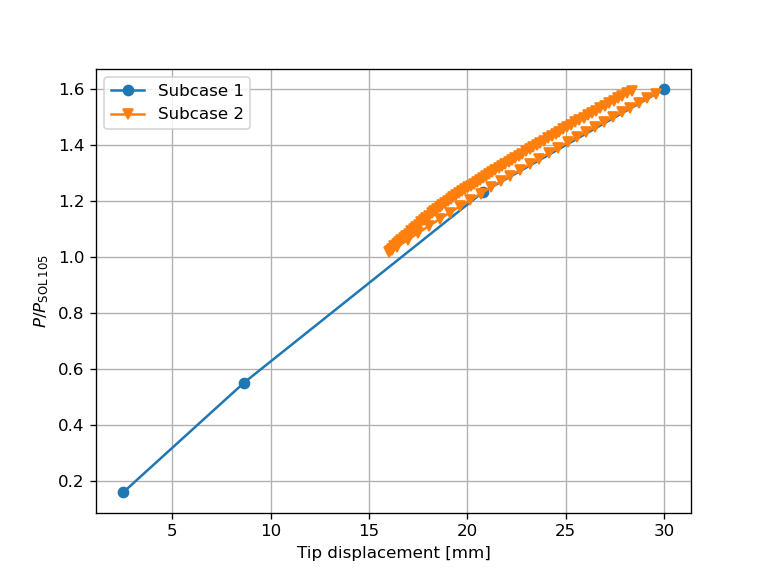

In [94]:
_, applied_loads_1_6Psol105_epsp1em3, tip_displacements_1_6Psol105_epsp1em3 = pynastran_utils.read_load_displacement_history_from_op2(op2_object=op2_output_1_6Psol105_epsp1em3, displacement_node_id=master_node_id)
plot_load_displacement_diagram(tip_displacements_1_6Psol105_epsp1em3, applied_loads_1_6Psol105_epsp1em3)

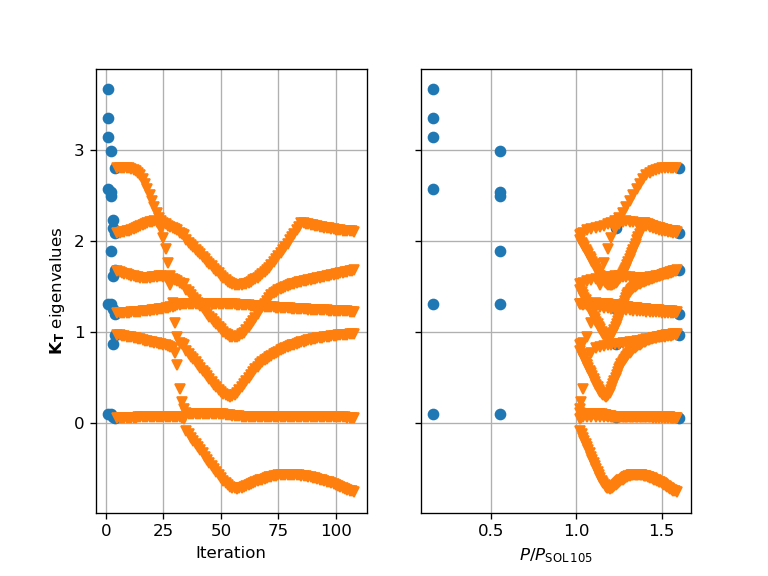

In [95]:
plot_tangent_stiffness_matrix_eigenvalues(analysis_directory_path, input_filename, applied_loads_1_6Psol105_epsp1em3)

Rerun analysis for $EPSP=10^{-1}, EPSW=10^{-1}$.

In [96]:
# Modify convergence tolerance of subcases 1 and 2
for subcase_id in range(1, 3):
    box_beam_bdf_input.nlparms[subcase_id].eps_p = 1e-1
    box_beam_bdf_input.nlparms[subcase_id].eps_w = 1e-1

box_beam_bdf_input.nlpcis[unloading_subcase_id].mxinc = 130


In [97]:
input_filename = f'bifurcation_verification_{load_factor:.1f}Psol105_epsp1e-1'.replace('.','_')
op2_output_1_6Psol105_epsp1em1 = pynastran_utils.run_tangent_stiffness_matrix_eigenvalue_calculation(bdf_object=box_beam_bdf_input.__deepcopy__({}), method_set_id=zero_load_set_id+1, no_eigenvalues=no_eigenvalues, analysis_directory_path=analysis_directory_path, input_name=input_filename, run_flag=False)

Nastran job bifurcation_verification_1_6Psol105_epsp1e-1.bdf completed
Wall time: 627.0 s


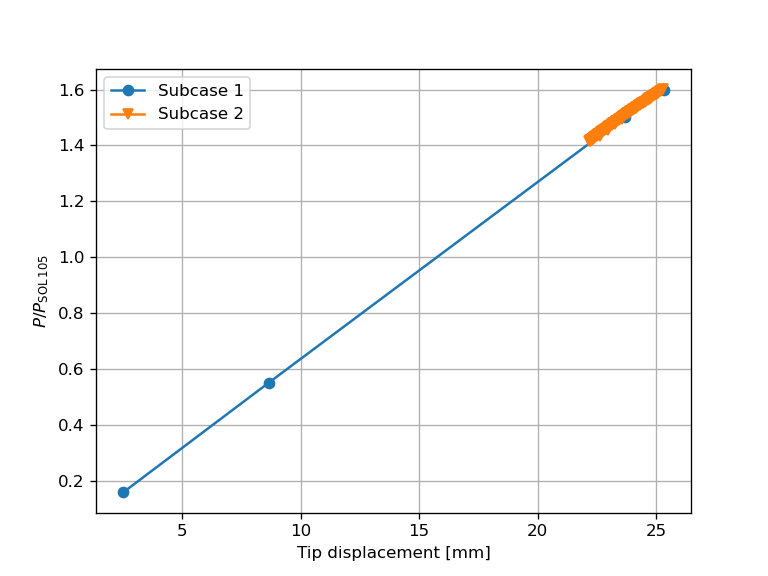

In [98]:
_, applied_loads_1_6Psol105_epsp1em1, tip_displacements_1_6Psol105_epsp1em1 = pynastran_utils.read_load_displacement_history_from_op2(op2_object=op2_output_1_6Psol105_epsp1em1, displacement_node_id=master_node_id)
plot_load_displacement_diagram(tip_displacements_1_6Psol105_epsp1em1, applied_loads_1_6Psol105_epsp1em1)

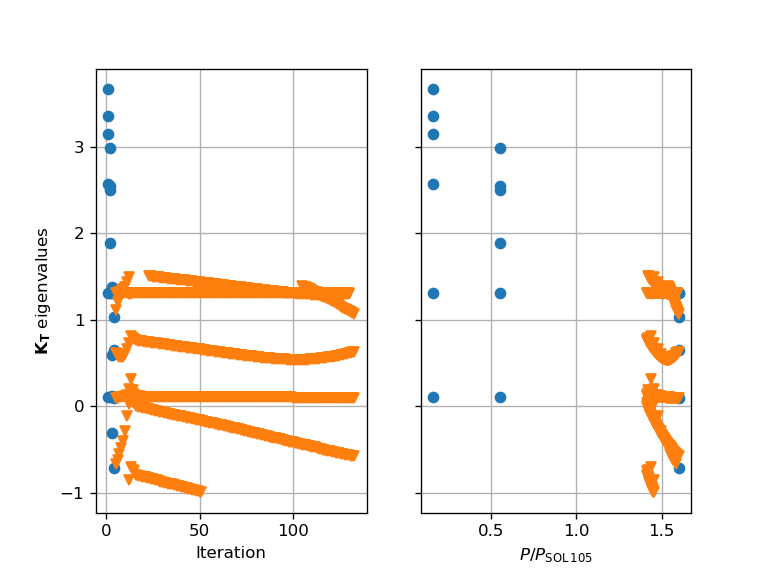

In [99]:
plot_tangent_stiffness_matrix_eigenvalues(analysis_directory_path, input_filename, applied_loads_1_6Psol105_epsp1em1)

Use very fine nonlinear analysis parameters.

In [100]:
load_factor = 2
box_beam_bdf_input.load_combinations[load_set_id][0].scale_factors[0] = sol_105_buckling_load*load_factor  # modify applied load
box_beam_bdf_input.case_control_deck.subcases[0].add_result_type('STRAIN', 'ALL', ['PLOT'])  # store strain data of all nodes in the op2 file

# Modify subcase 1
subcase_id = 1
box_beam_bdf_input.nlparms[subcase_id].ninc = 100
box_beam_bdf_input.nlparms[subcase_id].eps_p = 1e-3
box_beam_bdf_input.nlparms[subcase_id].eps_w = 1e-7
box_beam_bdf_input.nlpcis[subcase_id].minalr = 1e-2
box_beam_bdf_input.nlpcis[subcase_id].maxalr = 1.01
box_beam_bdf_input.nlpcis[subcase_id].desiter = 5
box_beam_bdf_input.nlpcis[subcase_id].mxinc = 100

# Delete subcase 2
del box_beam_bdf_input.subcases[2]

In [101]:
input_filename = 'bifurcation_verification_2Psol105_fine'
op2_output_2Psol105_fine = pynastran_utils.run_tangent_stiffness_matrix_eigenvalue_calculation(bdf_object=box_beam_bdf_input.__deepcopy__({}), method_set_id=zero_load_set_id+1, no_eigenvalues=no_eigenvalues, analysis_directory_path=analysis_directory_path, input_name=input_filename, run_flag=True)

Nastran job bifurcation_verification_2Psol105_fine.bdf completed
Wall time: 424.0 s


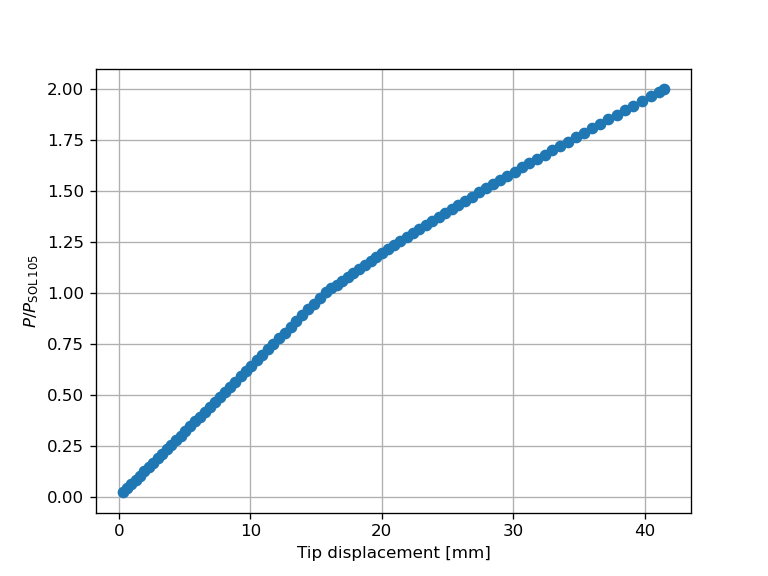

In [102]:
_, applied_loads_2Psol105_fine, tip_displacements_2Psol105_fine = pynastran_utils.read_load_displacement_history_from_op2(op2_object=op2_output_2Psol105_fine, displacement_node_id=master_node_id)

_, ax = plt.subplots()
ax.plot(tip_displacements_2Psol105_fine[subcase_id][:, displacement_component_index], applied_loads_2Psol105_fine[subcase_id][:, load_component_index]/sol_105_buckling_load, marker=markers[0])
plt.xlabel('Tip displacement [mm]')
plt.ylabel('$P/P_\mathrm{SOL\/105}$')
plt.grid()
plt.show()

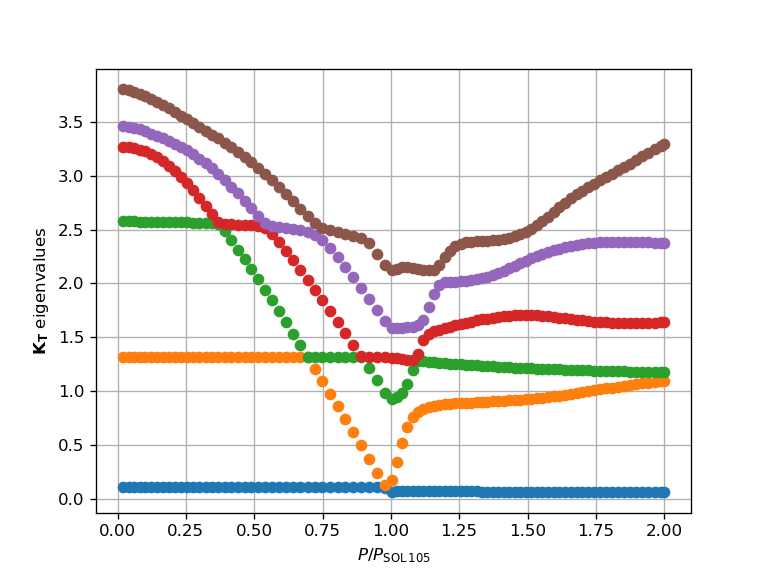

In [103]:
# Read eigenvalues of tangent stiffness matrix
f06_filepath = os.path.join(analysis_directory_path, input_filename + '.f06')  # path to .f06 file
eigenvalues = pynastran_utils.read_kllrh_lowest_eigenvalues_from_f06(f06_filepath)

# Plot lowest eigenvalues vs applied load
_, ax = plt.subplots()
ax.plot(applied_loads_2Psol105_fine[subcase_id][:, displacement_component_index]/sol_105_buckling_load, eigenvalues.T, markers[0])
ax.set_xlabel('$P/P_\mathrm{SOL\/105}$')
ax.set_ylabel('$\mathbf{K_T}$ eigenvalues')
ax.grid(visible=True)
plt.show()

Let's calculate linear buckling with SOL 105 and find point of maximum displacement in the buckling shape.

In [104]:
del box_beam_bdf_input.subcases[1]  # delete subcase 1
input_filename = 'bifurcation_verification_sol_105'
op2_output = pynastran_utils.run_sol_105_buckling_analysis(bdf_object=box_beam_bdf_input.__deepcopy__({}), static_load_set_id=force_set_id, analysis_directory_path=analysis_directory_path, input_name=input_filename, run_flag=False)

Nastran job bifurcation_verification_sol_105.bdf completed
Wall time: 5.0 s


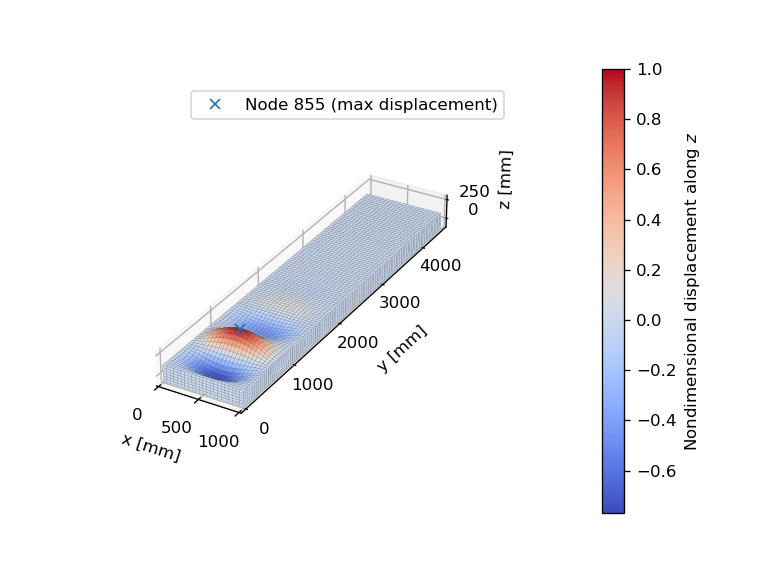

In [105]:
buckling_subcase_id = 2
max_displacement_node_id = np.argmax(op2_output.eigenvectors[buckling_subcase_id].data[0, :, 2]) + 1
_, ax = pynastran_utils.plot_buckling_mode(op2_object=op2_output, subcase_id=buckling_subcase_id, displacement_component= 'tz', colormap='coolwarm')  # plot buckling mode
max_displacement_node_xyz = op2_output.nodes[max_displacement_node_id].xyz + 200*op2_output.eigenvectors[buckling_subcase_id].data[0, max_displacement_node_id - 1, 0:3]
ax.plot(max_displacement_node_xyz[0], max_displacement_node_xyz[1], max_displacement_node_xyz[2], 'x', label=f'Node {max_displacement_node_id:d} (max displacement)', zorder=4)
ax.legend()

# We define a function to adjust axes ticks and labels' position, that we will use also later
def set_ticks_and_labels_position(axes):
    axes.locator_params(axis='x', nbins=3)  # set number of ticks of x-axis
    axes.locator_params(axis='z', nbins=2)  # set number of ticks of z-axis
    axes.tick_params(axis='y', which='major', pad=20)  # adjust position of ticks' label of y-axis
    axes.tick_params(axis='z', which='major', pad=6)  # adjust position of ticks' label of z-axis
    axes.yaxis.labelpad = 60  # adjust position of y-axis's label
    axes.zaxis.labelpad = 10  # adjust position of z-axis's label

# Set axes ticks and labels' position and show plot
set_ticks_and_labels_position(ax)
plt.show()

In [106]:
_, _, panel_displacements_1_6Psol105_epsp1em1 = pynastran_utils.read_load_displacement_history_from_op2(op2_object=op2_output_1_6Psol105_epsp1em1, displacement_node_id=max_displacement_node_id)
_, _, panel_displacements_1_6Psol105_epsp1em3 = pynastran_utils.read_load_displacement_history_from_op2(op2_object=op2_output_1_6Psol105_epsp1em3, displacement_node_id=max_displacement_node_id)
_, _, panel_displacements_2Psol105_epsp1em1 = pynastran_utils.read_load_displacement_history_from_op2(op2_object=op2_output_2Psol105_epsp1em1, displacement_node_id=max_displacement_node_id)
_, _, panel_displacements_2Psol105_fine = pynastran_utils.read_load_displacement_history_from_op2(op2_object=op2_output_2Psol105_fine, displacement_node_id=max_displacement_node_id)

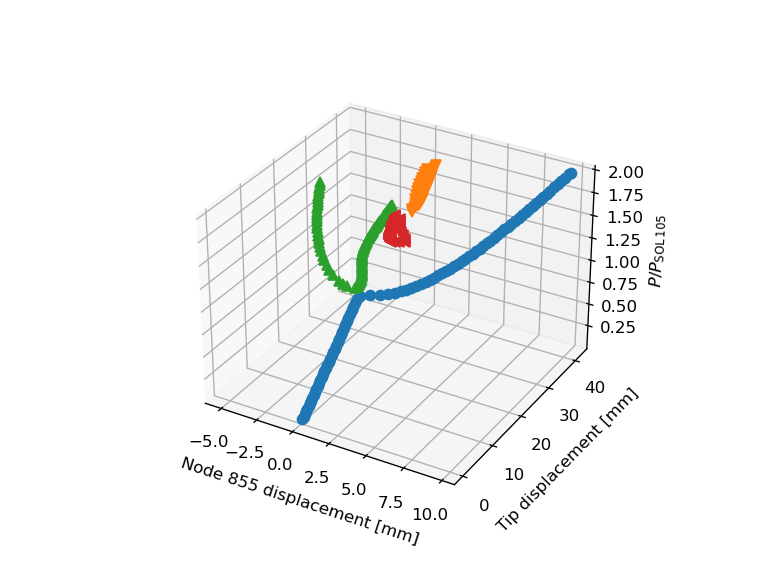

In [107]:
# Create figure with three-dimensional axes
plt.figure()
ax_3d = plt.axes(projection='3d')
# Plot load applied along x vs rotation of pin-supported node vs applied along y
ax_3d.plot3D(panel_displacements_2Psol105_fine[1][:, displacement_component_index], tip_displacements_2Psol105_fine[1][:, displacement_component_index], applied_loads_2Psol105_fine[1][:, load_component_index]/sol_105_buckling_load, markers[0], color=colors[0])  # sign of load along x is inverted to show a positive load in the plot
ax_3d.plot3D(panel_displacements_2Psol105_epsp1em1[2][:, displacement_component_index], tip_displacements_2Psol105_epsp1em1[2][:, displacement_component_index], applied_loads_2Psol105_epsp1em1[2][:, load_component_index]/sol_105_buckling_load, markers[1], color=colors[1])
ax_3d.plot3D(panel_displacements_1_6Psol105_epsp1em3[2][:, displacement_component_index], tip_displacements_1_6Psol105_epsp1em3[2][:, displacement_component_index], applied_loads_1_6Psol105_epsp1em3[2][:, load_component_index]/sol_105_buckling_load, markers[2], color=colors[2])
ax_3d.plot3D(panel_displacements_1_6Psol105_epsp1em1[2][:, displacement_component_index], tip_displacements_1_6Psol105_epsp1em1[2][:, displacement_component_index], applied_loads_1_6Psol105_epsp1em1[2][:, load_component_index]/sol_105_buckling_load, markers[3], color=colors[3])
# Set plot appearance
ax_3d.set_xlabel(f'Node {max_displacement_node_id:d} displacement [mm]')
ax_3d.set_ylabel('Tip displacement [mm]')
ax_3d.set_zlabel('$P/P_\mathrm{SOL\/105}$')
ax_3d.grid(visible=True)
plt.show()